##Import Libraries, Start Query Engine

In [184]:
import json
import ast
import pandas as pd
import csv
import requests
import time
import traceback
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import datetime
import instaconfig
from pytz import timezone

instagram, database, search_tags = instaconfig.config()

engine = create_engine('mysql://%(user)s:%(pass)s@%(host)s' % database)
engine.execute('use instagram_master')

In [178]:
q = '''
    SELECT *
    FROM posts
    WHERE searched_tag IN 
    %s ;
    ''' % ("('" + "','".join(search_tags[:]) + "')")  # :7

print q

df = pd.read_sql_query(q,con = engine)


    SELECT *
    FROM posts
    WHERE searched_tag IN 
    ('busk','busker','buskers','busking','streetmusic','streetmusician','streetmusicians','streetperformer','streetperformers','streetlife','livemusic') ;
    


In [179]:
print len(df)
df.head(1)

110212


,searched_tag,created_time,post_id,image_url,lat,likes,longitude,post_url,text,user_id,...,date_month,date_week,date_day,day_of_week,media_type,low_res_url,thumbnail_url,stand_res_url,live_music,genre
0,busk,1438400810,1041703958383645915_647156236,None,14.550606,184,121.051199,https://instagram.com/p/504Dsgk1Tb/,"Reposted from @hope_aaa ""His voice is just too...",1041703995016696991,...,7,None,31,4,video,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None


In [177]:
from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

## Train Kernel Density Estimator

In [180]:
Xtrain = np.vstack((df.longitude, df.lat)).T
Xtrain *= np.pi/180

kde = KernelDensity(
        bandwidth=1e-4, 
        kernel='epanechnikov',
        metric='haversine',
        #algorithm='ball_tree',
      )

kde.fit(Xtrain)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0001, breadth_first=True,
       kernel='epanechnikov', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

## Plot KDE and data points

Populating the interactive namespace from numpy and matplotlib


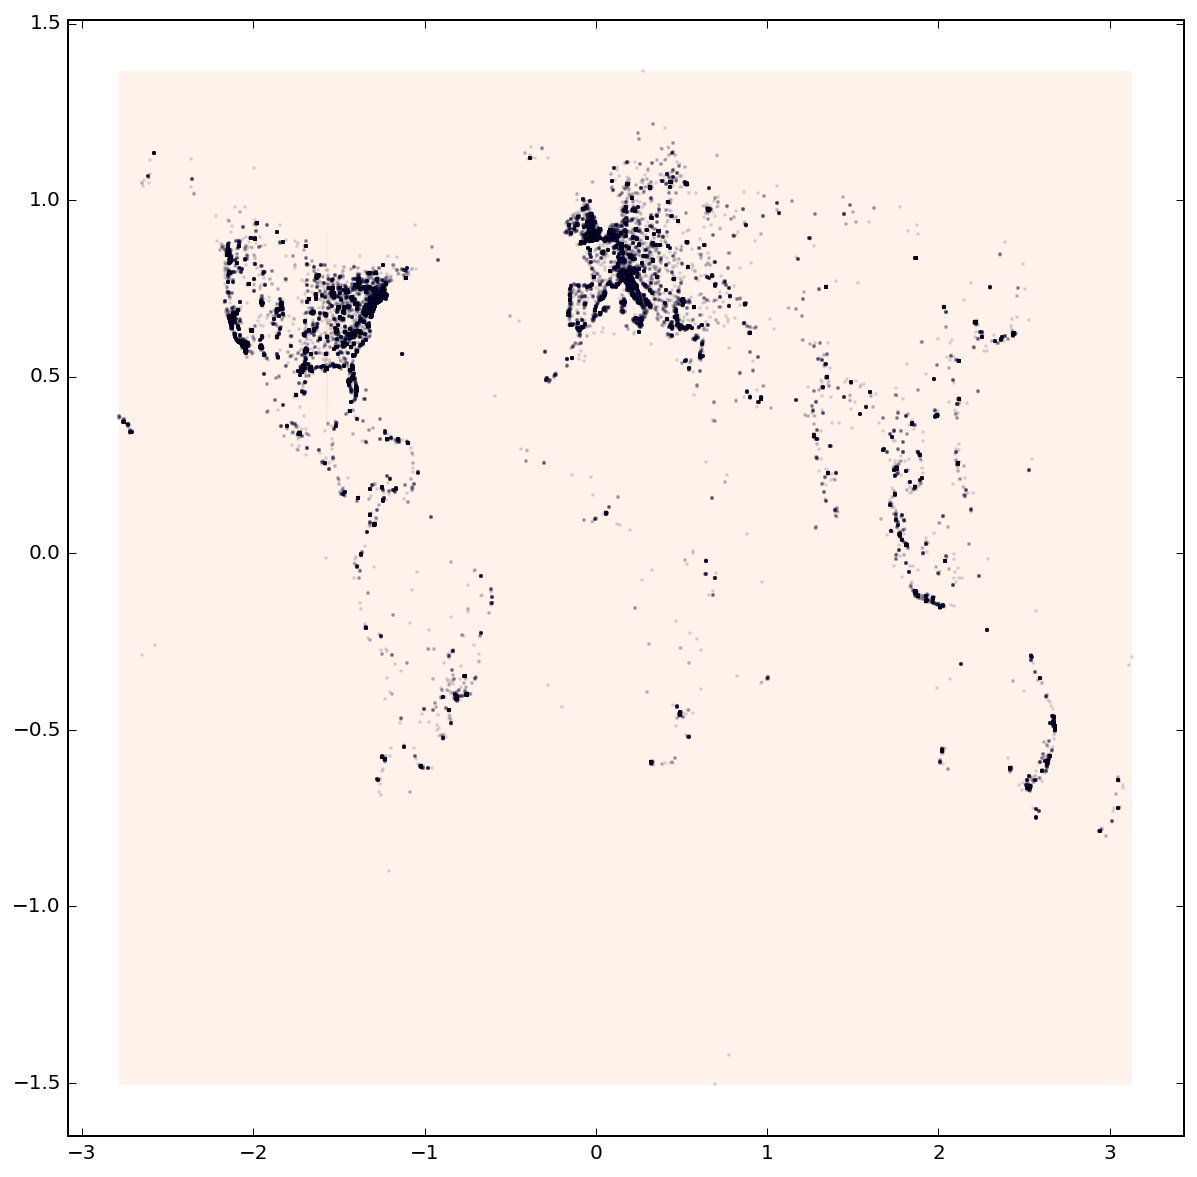

In [181]:
n = 1000
X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
X, Y = np.meshgrid(X, Y)
xy = np.vstack((X.flat, Y.flat)).T
logZ = kde.score_samples(xy).reshape(n,n)
Z = np.exp(logZ)

%config InlineBackend.figure_format='retina'
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

levels = np.linspace(0, Z.max(), 25)
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=1, alpha=0.1)

In [131]:
sf_coord = {
    'ul_lat' : 37.85,
    'ul_long' : -122.35,
    'lr_lat' : 37.7,
    'lr_long' : -122.6
    }

    #if 37.7 <= post['location']['latitude'] <= 37.85 \
    #                    and -122.6 <= post['location']['longitude'] <= -122.35:

In [182]:
def make_small_map(filter_coord, df):
    sf_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

    Xtrain = np.vstack((sf_df.longitude, sf_df.lat)).T
    Xtrain *= np.pi/180

    kde = KernelDensity(
            bandwidth=1e-4, 
            kernel='epanechnikov',
            metric='haversine',
            #algorithm='ball_tree',
          )

    kde.fit(Xtrain)

    n = 1000
    X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
    Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
    X, Y = np.meshgrid(X, Y)
    xy = np.vstack((X.flat, Y.flat)).T
    logZ = kde.score_samples(xy).reshape(n,n)
    Z = np.exp(logZ)

    pylab.rcParams['figure.figsize'] = (10, 10)

    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.scatter(Xtrain[:,0], Xtrain[:,1], s=1, alpha=0.1)

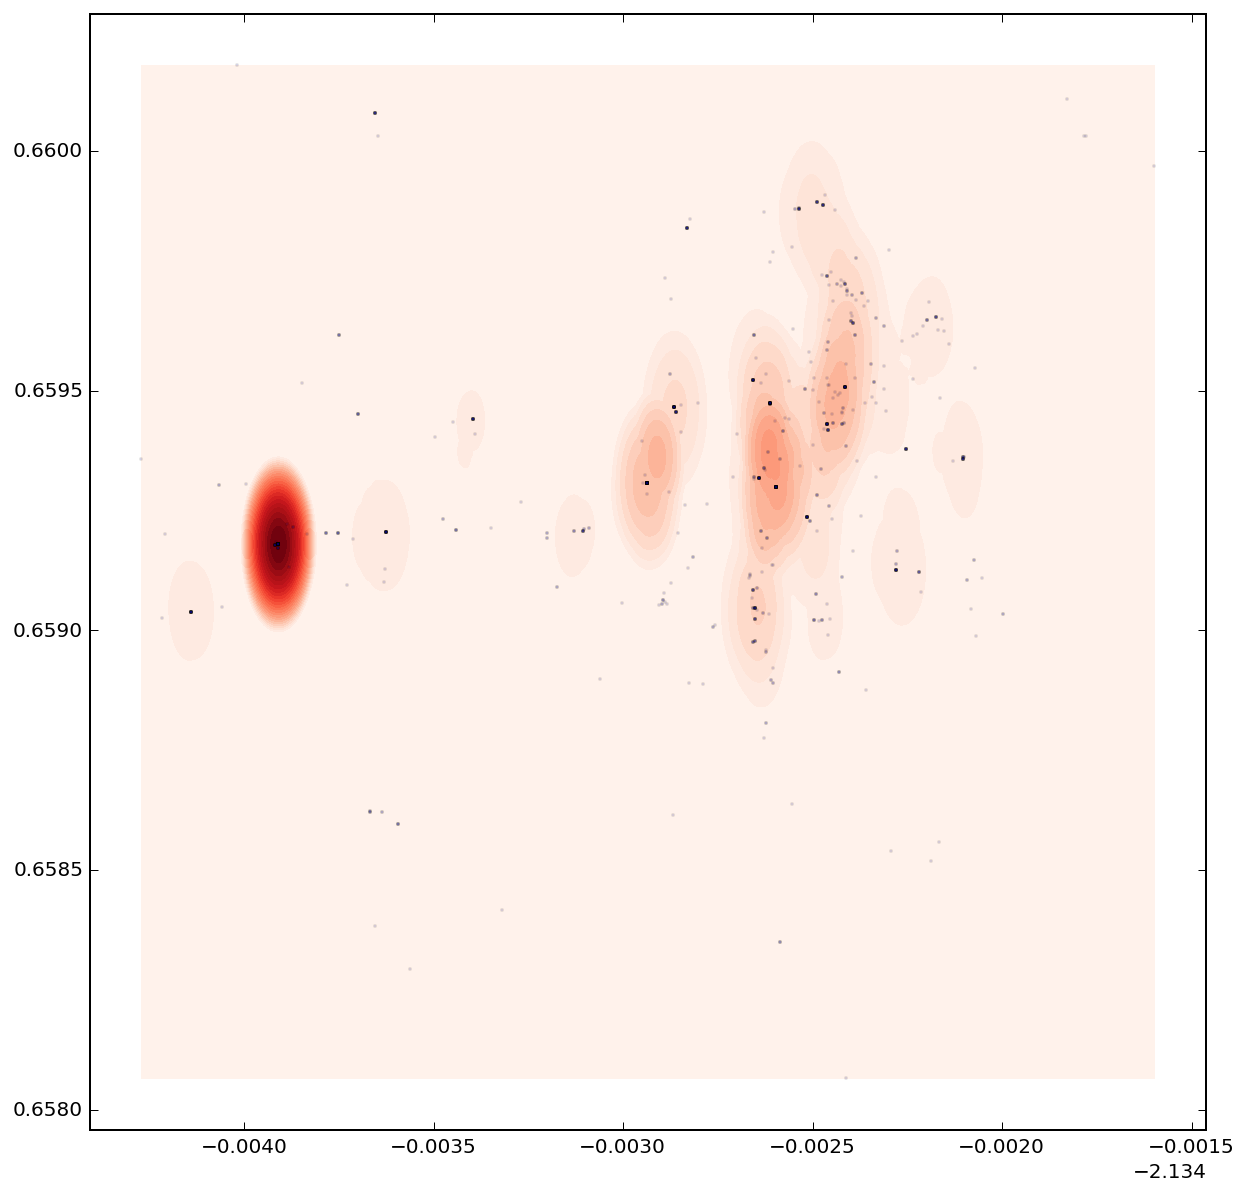

In [183]:
make_small_map(sf_coord, df)

<class 'pandas.core.frame.DataFrame'>


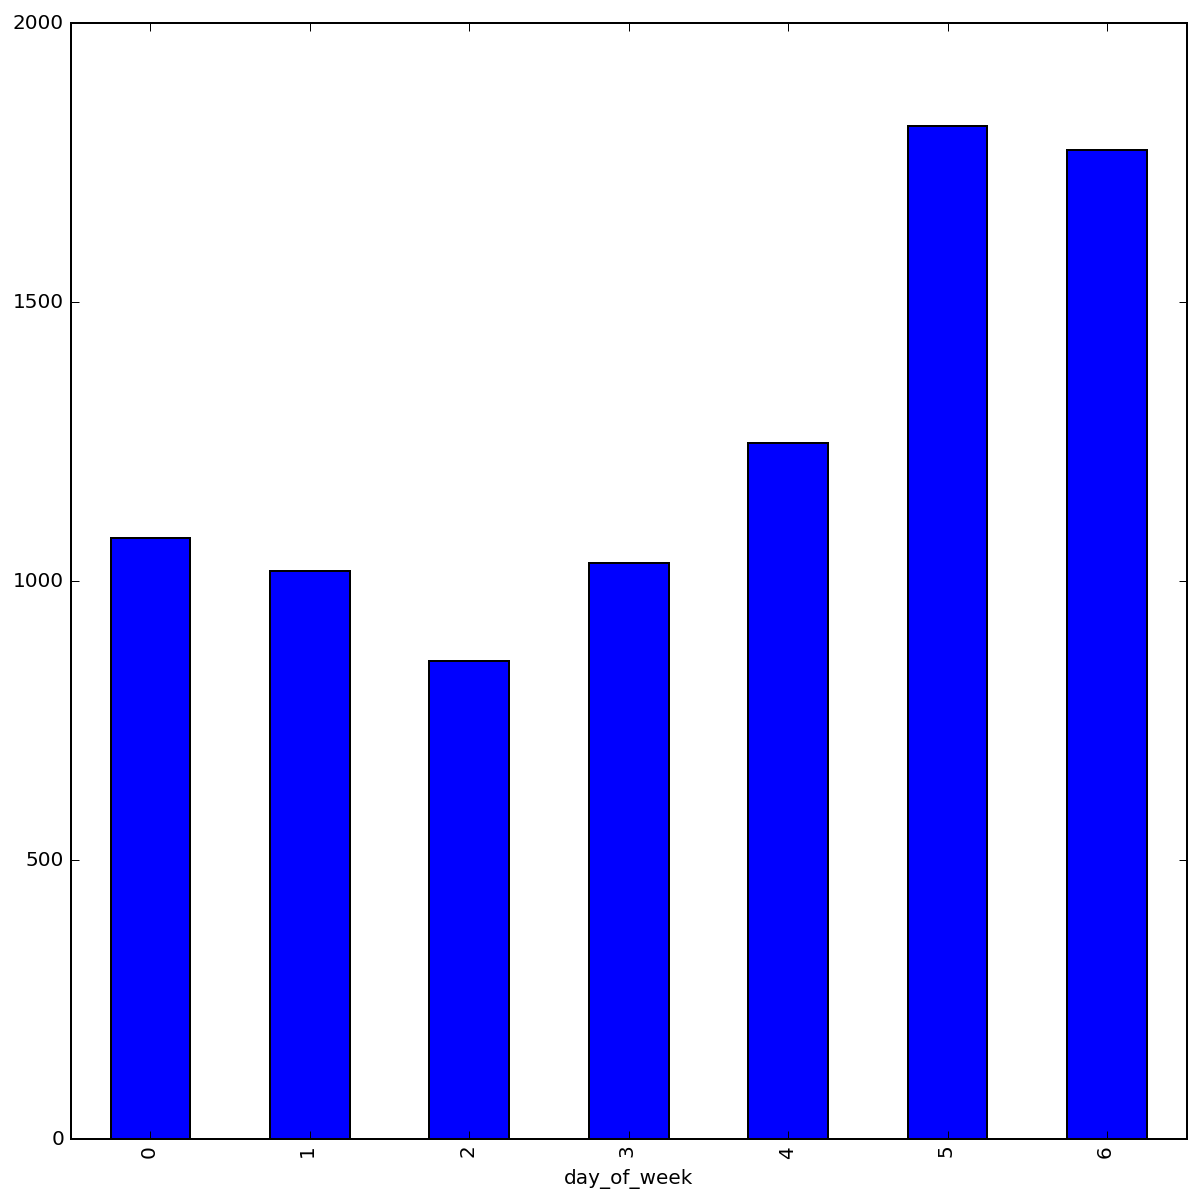

In [176]:
# Pictures binned by day of the week
df.groupby(['day_of_week']).count()['searched_tag'].plot(kind = 'bar')print type(df)

In [ ]:
# Pictures binned by day of the week
df.groupby(['day_of_week']).count()['searched_tag'].plot(kind = 'bar')print type(df)

In [ ]:
from mpl_toolkits.basemap import Basemap

Xdeg, Ydeg = X*180/np.pi, Y*180/np.pi

m = Basemap(projection='cyl', 
            llcrnrlat=Ydeg.min(),
            urcrnrlat=Ydeg.max(), 
            llcrnrlon=Xdeg.min(),
            urcrnrlon=Xdeg.max(), 
            resolution='h')

m.drawmapboundary(fill_color='aqua')
m.drawcoastlines()
#Zmask = maskoceans(Xdeg, Ydeg, Z, resolution='h', grid=1.25)
Zmask = Z

plt.contourf(Xdeg, Ydeg, Zmask, levels=levels, cmap=plt.cm.Reds);

## dbscan

In [146]:
import folium
from sklearn.cluster import DBSCAN
from IPython.display import IFrame
from geopy.distance import EARTH_RADIUS

def make_small_map_dbscan(filter_coord, df):
    filtered_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

    filtered_df
    Xtrain = np.vstack((filtered_df.longitude, filtered_df.lat)).T
    Xtrain *= np.pi/180

    print Xtrain
    n = 1000
    radians_per_meter = 1e-3 * EARTH_RADIUS

    db = DBSCAN(
            eps=50*radians_per_meter,
            min_samples=10,
            metric='haversine',
         )

    db.fit(Xtrain)
    
    n = 100
    X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
    Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
    X, Y = np.meshgrid(X, Y)

    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.scatter(
        Xtrain[:,0], 
        Xtrain[:,1], 
        c=db.labels_, 
        s=20,
        lw=0,
        cmap=plt.cm.Greys)
    

[[-2.13713047  0.65920767]
 [-2.1364731   0.65988769]
 [-2.13734755  0.65921316]
 [-2.13710326  0.65921131]
 [-2.13664751  0.65908885]
 [-2.13762594  0.65920601]
 [-2.13641483  0.65950807]
 [-2.13713047  0.65920767]
 [-2.13641483  0.65950807]
 [-2.13653701  0.6598806 ]
 [-2.13688917  0.65973478]
 [-2.13654707  0.65987968]
 [-2.13659716  0.65929812]
 [-2.13659716  0.65929812]
 [-2.13623452  0.65961325]
 [-2.13638546  0.65968847]
 [-2.13613936  0.65959682]
 [-2.13653677  0.65987896]
 [-2.13642524  0.65971787]
 [-2.13659716  0.65929812]
 [-2.13682565  0.65888989]
 [-2.13633214  0.65931896]
 [-2.13641483  0.65950807]
 [-2.13641875  0.65946343]
 [-2.13640887  0.65969922]
 [-2.13654707  0.65987968]
 [-2.13648809  0.65920827]
 [-2.13664751  0.65908885]
 [-2.13762594  0.65920601]
 [-2.1364731   0.65988769]
 [-2.13659716  0.65929812]
 [-2.13641483  0.65950807]
 [-2.13660953  0.65889655]
 [-2.13631233  0.65950441]
 [-2.13659716  0.65929812]
 [-2.13641483  0.65950807]
 [-2.13641483  0.65950807]
 

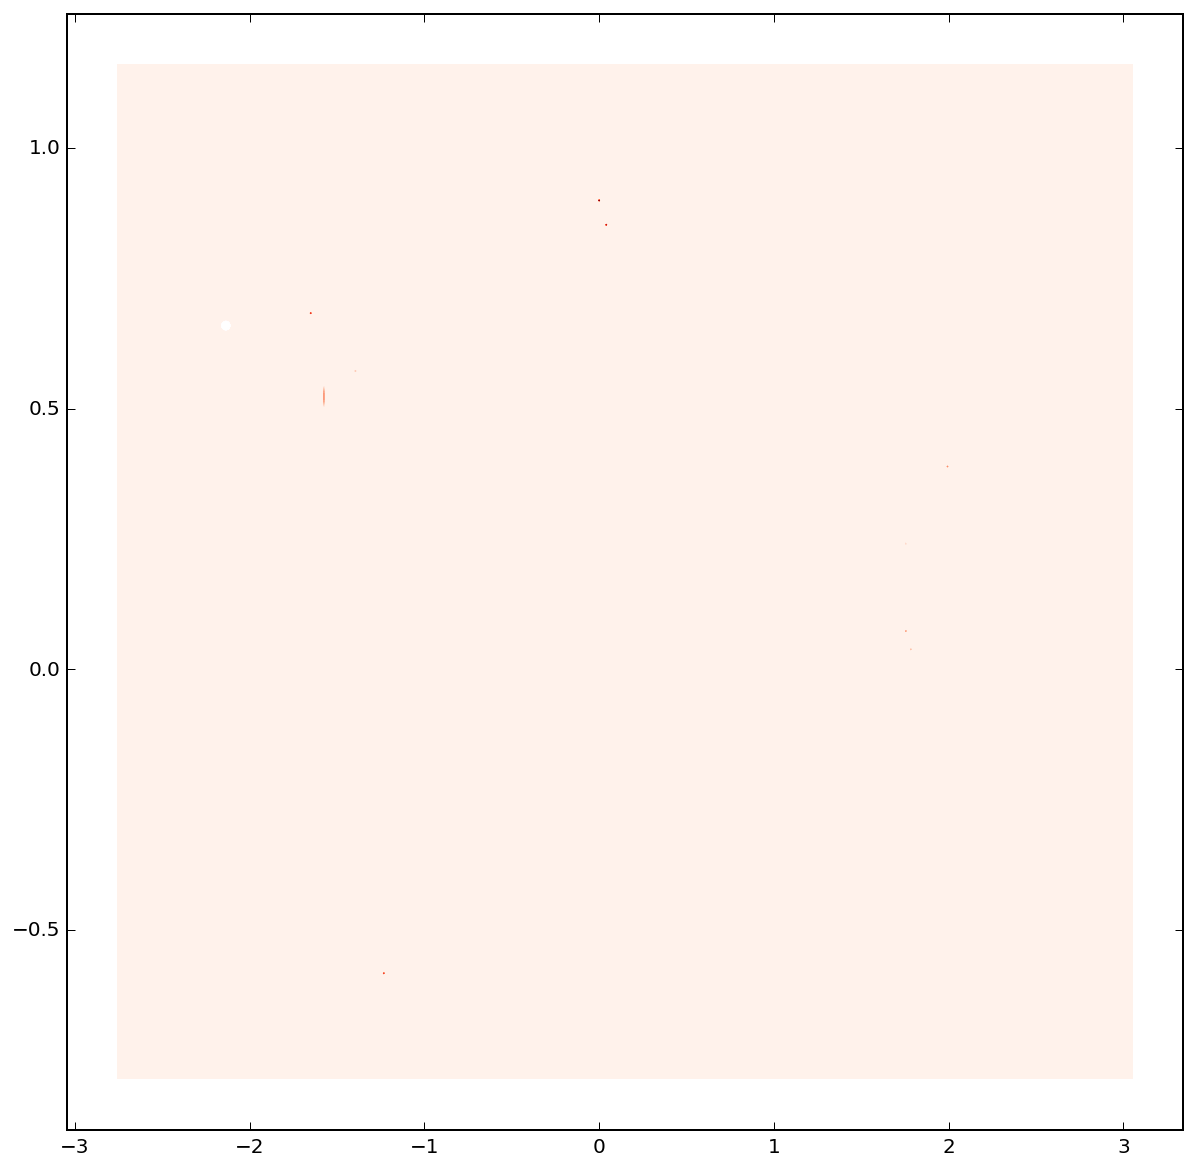

In [147]:
make_small_map_dbscan(sf_coord, df)

In [153]:
df

,searched_tag,created_time,post_id,image_url,lat,likes,longitude,post_url,text,user_id,...,date_month,date_week,date_day,day_of_week,media_type,low_res_url,thumbnail_url,stand_res_url,live_music,genre
0,busk,1438400810,1041703958383645915_647156236,None,14.550606,184,121.051199,https://instagram.com/p/504Dsgk1Tb/,"Reposted from @hope_aaa ""His voice is just too...",1041703995016696991,...,7,None,31,4,video,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
1,busk,1438456312,1042169544525807130_241948134,None,56.264634,6,10.062234,https://instagram.com/p/52h63ZMP4a/,#????#?????#?????#hinnerup#sommer#blomster#aft...,1042169546136420340,...,8,None,1,5,image,https://scontent.cdninstagram.com/hphotos-xap1...,https://scontent.cdninstagram.com/hphotos-xap1...,https://scontent.cdninstagram.com/hphotos-xap1...,None,None
2,busk,1438462981,1042225487949635640_1798861575,None,45.427681,12,-75.692497,https://instagram.com/p/52uo8xGKA4/,I like their outfits and they sound good too #...,1042225493897158799,...,8,None,1,5,image,https://scontent.cdninstagram.com/hphotos-xfa1...,https://scontent.cdninstagram.com/hphotos-xfa1...,https://scontent.cdninstagram.com/hphotos-xfa1...,None,None
3,busk,1438526045,1042754508675112035_1349825278,None,55.451759,10,10.427090,https://instagram.com/p/54m7NthFxj/,#stempelkaffe #ribsmuffin #wendorff #kaffemeds...,1043611128460238038,...,8,None,2,6,image,https://scontent.cdninstagram.com/hphotos-xfa1...,https://scontent.cdninstagram.com/hphotos-xfa1...,https://scontent.cdninstagram.com/hphotos-xfa1...,None,None
4,busk,1438539653,1042868654368749491_444345636,None,58.383300,28,8.700000,https://instagram.com/p/55A4QLCfez/,????????? #hortensia #nydeligefarger #busk #bl...,1057925159468004864,...,8,None,2,6,image,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
5,busk,1438632783,1043649888369364950_309617162,None,59.612122,40,10.207380,https://instagram.com/p/57ygtCIc_W/,#rips #b?r #busk #hund #aussie #bella #foxy #r...,1046397358656572770,...,8,None,3,0,image,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
6,busk,1438636361,1043679901175728992_184284817,None,40.757454,18,-73.990675,https://instagram.com/p/575Vcoy0tg/,These cats are in the NYC subways killing it e...,1043685008579709696,...,8,None,3,0,video,https://scontent.cdninstagram.com/hphotos-xpa1...,https://scontent.cdninstagram.com/hphotos-xpa1...,https://scontent.cdninstagram.com/hphotos-xpa1...,None,None
7,busk,1438685007,1044087978021125732_313948358,None,5.810122,44,102.148716,https://instagram.com/p/59WHv0NH5k/,"? RUPA \nsetiap kali awaa pandang saia, saia a...",1044087980931972895,...,8,None,4,1,image,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
8,busk,1438784317,1044921050313562718_1374204389,None,25.576266,58,91.882480,https://instagram.com/p/6ATii2RJpe/,Swag i guess! :') thanks y'all for stopping an...,1044924083642604511,...,8,None,5,2,image,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
9,busk,1438898735,1045880858063089125_502098786,None,41.383662,18,2.164821,https://instagram.com/p/6DtxleOy3l/,Thursday nights are my jam. #jam #music #music...,1045881175253135090,...,8,None,6,3,image,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None
